# Aspen Community Clustering Project

This notebook documents the development and evaluation process of a clustering algorithm with the goal of confidently classifying a GitHub project into a 'stage of maturity'.

Current focus areas: 

* Expanding feature set
* Identifying important features 
* Identifying optimal number of clusters

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing as pp
import json
import sqlalchemy as salc
from google.colab import drive
import pandas as pd
from time import gmtime
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import plotly.express as px
from sklearn.decomposition import PCA
from statistics import mean 
import datetime
import seaborn as sns

In [2]:
#Linking to Gdrive 
drive.mount('/content/drive', force_remount=True)

#change your folder path (where you want your files to be saved to or pulled from) 
%cd /content/drive/MyDrive/Aspen Research

Mounted at /content/drive
/content/drive/MyDrive/Aspen Research


In [3]:
with open("copy_cage-padres.json") as config_file: # MS changed path from ../comm_cage.json
    config = json.load(config_file)

In [4]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Feature Engineering
Augur Schema : https://oss-augur.readthedocs.io/en/main/schema/overview.html

In [5]:
# Query to retrieve basic repository information
basic_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated, 
              r.committers_count as committers,
              r.commit_count as commits,
              CASE WHEN r.committers_count > 0 THEN r.commit_count / r.committers_count ELSE 0 END AS commits_per_committer,
              r.pull_requests_open as prs_open,
              r.pull_requests_closed as prs_closed,
              r.pull_requests_merged as prs_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count as forks,
              r.license_file as license, 
              r.code_of_conduct_file as coc, 
              r.stars_count as stars,
              r.watchers_count as watchers, 
              r.issues_enabled
          FROM repo_groups a
          JOIN repo b ON a.repo_group_id = b.repo_group_id
          JOIN repo_info r ON r.repo_id = b.repo_id AND r.repo_info_id = (
              SELECT MAX(r2.repo_info_id)
              FROM repo_info r2
              WHERE r2.repo_id = b.repo_id
          )
""")
basic_results = pd.read_sql_query(basic_query, con=engine)

# Query to retrieve derived repository metrics
derived_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT
                 b.repo_id,
                 (SELECT AVG(c.cmt_added) FROM commits c WHERE c.repo_id = b.repo_id) AS avg_commit_length,
                 (SELECT AVG(i.comment_count) FROM issues i WHERE i.repo_id = b.repo_id) AS avg_i_comment_count,
                 AVG(DATE_PART('hour',pr.pr_closed_at - pr.pr_created_at)) as avg_time_to_close,
                 AVG(DATE_PART('hour',pr.pr_merged_at - pr.pr_created_at)) as avg_time_to_merge,
                 (SELECT AVG(commit_count) AS avg_commits_per_pr
                  FROM (SELECT pr.pull_request_id, COUNT(prc.pr_cmt_id) AS commit_count
                        FROM pull_request_commits prc
                        JOIN pull_requests pr ON prc.pull_request_id = pr.pull_request_id
                        WHERE pr.repo_id = b.repo_id
                        GROUP BY pr.pull_request_id
                       ) AS pr_commits
                 ) AS avg_commits_per_pr
          FROM repo b
          LEFT JOIN pull_requests pr ON pr.repo_id = b.repo_id
          GROUP BY b.repo_id
""")
derived_results = pd.read_sql_query(derived_query, con=engine)

# Join the results of the queries to create the final 'repos' dataframe
repos = basic_results.merge(derived_results, on='repo_id')
repos = repos.fillna(0) # change NaN values to 0
display(repos)
repos.dtypes

rg_name  repo_group_id  \
0      Issue oss-aspen issue 269            222   
1      Issue oss-aspen issue 269            222   
2                         coreos          25458   
3      Issue oss-aspen issue 269            222   
4      Issue oss-aspen issue 269            222   
...                          ...            ...   
13753                    grafana         100141   
13754                     apache          25478   
13755                    grafana         100141   
13756             RedHatInsights          25644   
13757                      teiid          25569   

                                       repo_name  repo_id        last_updated  \
0                        vscode-kubernetes-tools    64781 2023-03-09 09:02:25   
1                                deployments-k8s    64789 2023-02-22 02:50:32   
2                             systemd-deprecated    27872 2023-01-28 15:57:52   
3                           opendatahub-operator    64791 2023-02-23 14:30:33   
4                          opendatahub-community    64793 2023-03-07 11:37:49   
...                                          ...      ...                 ...   
13753                          database-migrator    63647 2023-03-14 03:01:03   
13754                 openwhisk-package-cloudant    29959 2023-03-02 18:56:47   
13755  example-kubernetes-autoscaling-nodejs-api    63625 2022-12-19 20:19:58   
13756                                 es-cleanup    35718 2022-08-04 13:59:12   
13757                          teiid-web-console    33802 2019-06-25 17:16:33   

       committers  commits  commits_per_committer  prs_open  prs_closed  ...  \
0              77    593.0                    7.0         8          38  ...   
1              20      0.0                    0.0        19          63  ...   
2             321  20232.0                   63.0         0           3  ...   
3              42    234.0                    5.0         6          22  ...   
4               8     43.0                    5.0         3           3  ...   
...           ...      ...                    ...       ...         ...  ...   
13753           4     29.0                    7.0         0           1  ...   
13754          17    179.0                   10.0         2          11  ...   
13755           4     11.0                    2.0         7           1  ...   
13756           3     33.0                   11.0         0           1  ...   
13757           8    215.0                   26.0         0          11  ...   

                                              license  \
0      http://choosealicense.com/licenses/apache-2.0/   
1      http://choosealicense.com/licenses/apache-2.0/   
2         http://choosealicense.com/licenses/gpl-2.0/   
3      http://choosealicense.com/licenses/apache-2.0/   
4         http://choosealicense.com/licenses/gpl-3.0/   
...                                               ...   
13753  http://choosealicense.com/licenses/apache-2.0/   
13754  http://choosealicense.com/licenses/apache-2.0/   
13755         http://choosealicense.com/licenses/mit/   
13756                                               0   
13757                                               0   

                                                     coc  stars  watchers  \
0      https://github.com/vscode-kubernetes-tools/vsc...    584        28   
1                                                      0     25         3   
2                                                      0      6        26   
3                                                      0     33         8   
4      https://github.com/opendatahub-io/opendatahub-...     17         9   
...                                                  ...    ...       ...   
13753                                                  0     55       110   
13754  https://github.com/apache/.github/blob/master/...     17        38   
13755                                                  0     13       114   
13756                  

rg_name                          object
repo_group_id                     int64
repo_name                        object
repo_id                           int64
last_updated             datetime64[ns]
committers                        int64
commits                         float64
commits_per_committer           float64
prs_open                          int64
prs_closed                        int64
prs_merged                        int64
open_issues                       int64
issues_closed                     int64
forks                             int64
license                          object
coc                              object
stars                             int64
watchers                          int64
issues_enabled                   object
avg_commit_length               float64
avg_i_comment_count             float64
avg_time_to_close               float64
avg_time_to_merge               float64
avg_commits_per_pr              float64
dtype: object

In [6]:
# issues_enabled object to bool int
repos.loc[repos.issues_enabled == 'true', 'issues_enabled'] = 1
repos.loc[repos.issues_enabled == 'false', 'issues_enabled'] = 0
repos.issues_enabled = repos.issues_enabled.astype(int)

In [7]:
# days since last update
now = datetime.datetime.now()
repos.last_updated.apply(lambda d: pd.to_datetime(str(d)))
repos.last_updated = (now - repos.last_updated).astype('timedelta64[D]')
repos.last_updated = repos.last_updated.astype(int)

In [8]:
# object to binary int for licence and coc
repos.loc[repos.license != 0, 'license'] = 1
repos.loc[repos.coc != 0, 'coc'] = 1

repos.license = repos.license.astype(int)
repos.coc = repos.coc.astype(int)

## Current Working Dataset

* Features (for each repo):

      General:
       # committers
       # commits 
       # commits/#committers 
       # prs open
       # prs closed 
       # prs merged 
       # issues open 
       # issues closed
       avg length of commit 
       # commits per pr

      Interest:
       # forks 
       # stars
       # watchers 

      Open-source(ness):
       ease of contribution score (0-3) 
            - license, code of conduct, issues enabled 
              (sum of binary features)

      Maintainer responsiveness:
       avg #comments per issue
       avg time to close (pr)
       avg time to merge (pr)

      Project velocity: 
       # days since last update
 
* Current total # of features: 18


In [9]:
repo_set = []
repo_set = np.array([repos.committers, repos.commits, repos.commits_per_committer, repos.prs_open, 
                     repos.prs_closed, repos.prs_merged, repos.open_issues, repos.issues_closed, 
                     repos.forks, repos.stars, repos.watchers, repos.last_updated, 
                     (repos.license + repos.coc + repos.issues_enabled), repos.avg_commit_length, 
                     repos.avg_i_comment_count, repos.avg_time_to_close, repos.avg_time_to_merge, 
                     repos.avg_commits_per_pr]).astype(np.int64).transpose()

In [10]:
# norm (unit var and zero mean)
scaler = pp.StandardScaler().fit(repo_set)
repo_set = scaler.transform(repo_set)

In [11]:
df_repo_set = pd.DataFrame(repo_set, columns = ["committers","commits","commits_per_commiters","prs_open",
                 "prs_closed", "prs_merged", "issues_open","issues_closed", "forks", "stars", "watchers", 
                 "last_updated", "ease_of_contr", "avg_commit_length","avg_i_comment_count", "pr_time_to_close", 
                 "pr_time_to_merge", "avg_commits_per_pr"])
df_repo_set.head()

committers   commits  commits_per_commiters  prs_open  prs_closed  \
0    0.779066 -0.048957              -0.028804  0.167415   -0.022946   
1   -0.136587 -0.077915              -0.031541  0.612536    0.022484   
2    4.698704  0.910064              -0.006907 -0.156309   -0.086547   
3    0.216823 -0.066488              -0.029586  0.086484   -0.052021   
4   -0.329356 -0.075815              -0.029586 -0.034912   -0.086547   

   prs_merged  issues_open  issues_closed     forks     stars  watchers  \
0    0.242616     2.421583       0.403825  0.160272  0.141238  0.012810   
1    6.656187     0.377206       0.073621 -0.076983 -0.085395 -0.202446   
2   -0.133448    -0.131294      -0.099965 -0.098021 -0.093098 -0.004410   
3   -0.085356     0.148900       0.013583 -0.075815 -0.082152 -0.159395   
4   -0.123987    -0.100161      -0.097355 -0.083996 -0.088639 -0.150785   

   last_updated  ease_of_contr  avg_commit_length  avg_i_comment_count  \
0     -0.650406       1.561192          -0.170511             1.062046   
1     -0.629816       0.290102          -0.166201             1.062046   
2     -0.595498      -0.980988          -0.138186            -0.385653   
3     -0.631189       0.290102          -0.170511             0.096913   
4     -0.647661       1.561192          -0.170511             0.096913   

   pr_time_to_close  pr_time_to_merge  avg_commits_per_pr  
0          1.128851          1.319399            0.110049  
1         -0.995503         -0.889178           -0.105367  
2          1.128851         -0.889178            4.418358  
3          0.916415          1.319399            0.540880  
4          2.403463          2.423688            0.110049

In [12]:
# save data to drive
df_repo_set.to_csv('/features.csv', index=False)

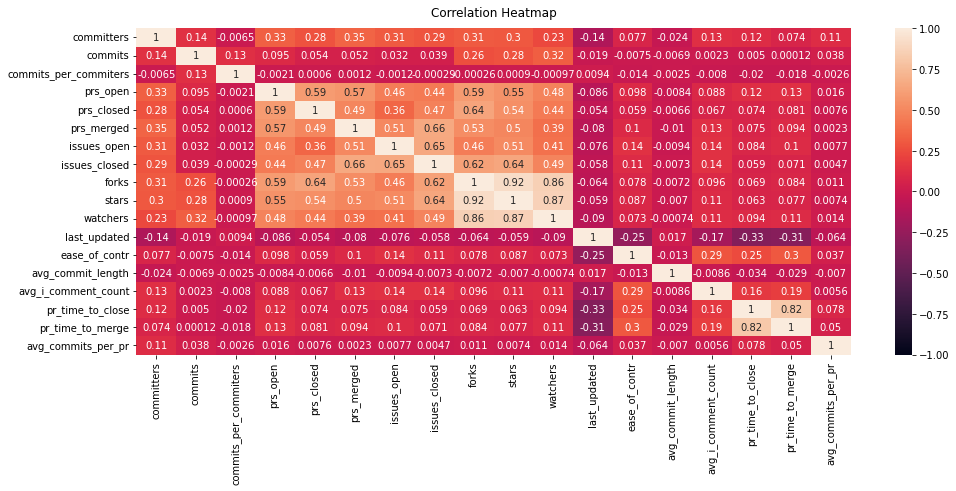

In [13]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_repo_set.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Identifying Optimal number of Clusters 

Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Clusters')

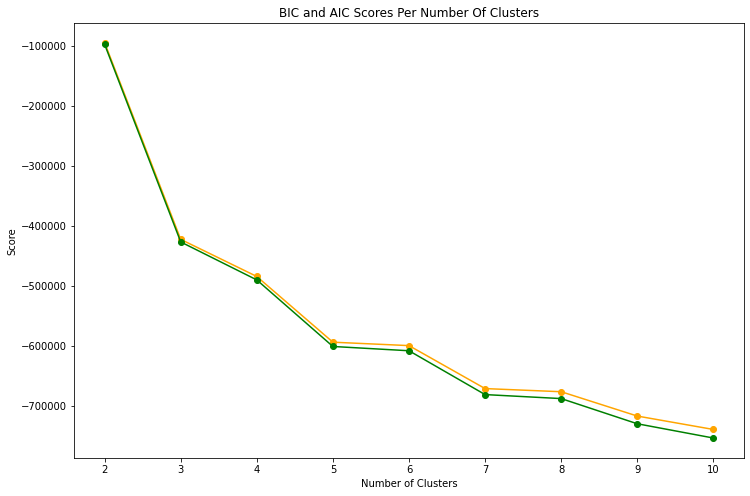

In [14]:
# cluster numbers to try
n_range = range(2,11)

bic_score = [] # Bayesian information criterion
aic_score = [] # Akaike information criterion

for n in n_range:
    gmm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=10)
    gmm.fit(repo_set)
    
    bic_score.append(gmm.bic(repo_set))
    aic_score.append(gmm.aic(repo_set))
    
# Plot the BIC and AIC 
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

## Scatter Matrix of GMM predictions

Gaussian Mixture Model: [scikit-learn documentation](https://scikit-learn.org/stable/modules/mixture.html)

In [15]:
gmm = GaussianMixture(n_components=4).fit(df_repo_set)
groups = gmm.predict(df_repo_set)

fig = px.scatter_matrix(df_repo_set, title = "GMM predictions with 4 Categories",
            width=1800, height=1800, color=groups)
fig.show()

## Principal component analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space to allow us to visualize all 6 dimensions on one plot. 

In [16]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_repo_set)

fig = px.scatter(components, color=groups, title = "GMM predictions with 4 Categories")
fig.show()

In [17]:
pca = PCA(n_components=3)
components = pca.fit_transform(df_repo_set)
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(components,x=0, y=1, z=2, color=groups,title=f'Total Explained Variance: {total_var:.2f}%')
fig.show()

## Magnitude of each feature value

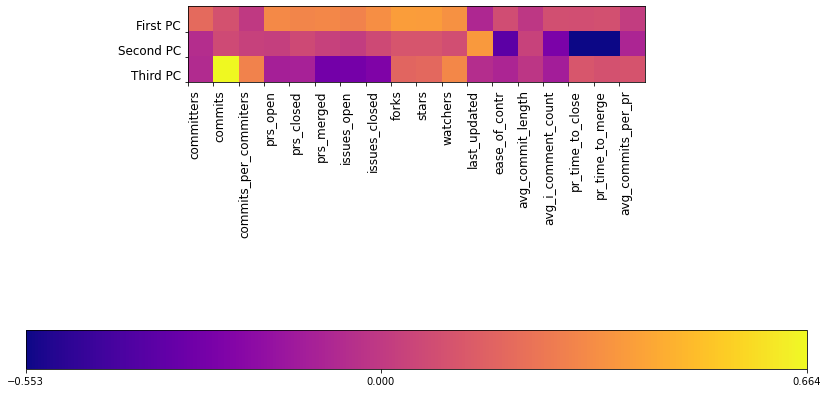

In [18]:
fig = plt.figure(figsize=(14, 7))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')

plt.gca().set_xticks(np.arange(-.5, len(df_repo_set.columns)-1));
plt.gca().set_yticks(np.arange(0.5, 3));
plt.gca().set_xticklabels(df_repo_set.columns, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC', 'Third PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0,
                                              pca.components_.max()], pad=0.65);

## How many features (principal components) do we need?

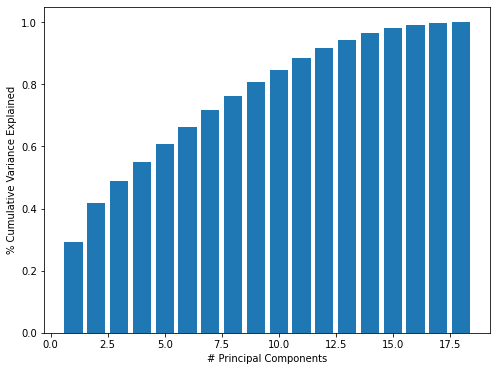

In [35]:
pca = PCA(n_components=18)
pca.fit(df_repo_set)
components = pca.transform(df_repo_set)
cum_exp_var = []
var_exp = 0
for i in pca.explained_variance_ratio_:
    var_exp += i
    cum_exp_var.append(var_exp)

# Plot cumulative explained variance for all PCs
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(range(1,19), cum_exp_var)
ax.set_xlabel('# Principal Components')
ax.set_ylabel('% Cumulative Variance Explained');

## Cluster statistics

In [19]:
for color in range(max(groups)+1):
  print("\nCluster #",color)
  c = np.where(groups == color)
  print("Repo count:", len(c[0]))
  print("Cluster statistics:")
  display(repos.iloc[c[0]].describe())
  print("\nRepo examples:")
  for i, y in enumerate(c[0]):
    print(repos.iloc[y].rg_name,":",repos.iloc[y].repo_name)
    if i == 10:
      break


Cluster # 0
Repo count: 3431
Cluster statistics:


repo_group_id       repo_id  last_updated   committers        commits  \
count    3431.000000   3431.000000   3431.000000  3431.000000    3431.000000   
mean    45764.696881  39841.068493    188.377441    52.881084    1591.942874   
std     33629.925225  14784.406803    376.994427    80.042357    4867.899643   
min       222.000000  25431.000000      0.000000     0.000000       0.000000   
25%     25478.000000  29016.500000     40.000000    10.000000       0.000000   
50%     25536.000000  32480.000000     47.000000    22.000000     274.000000   
75%    100105.000000  61228.000000    131.000000    52.000000    1121.000000   
max    100147.000000  64901.000000   3508.000000   444.000000  152502.000000   

       commits_per_committer     prs_open   prs_closed   prs_merged  \
count            3431.000000  3431.000000  3431.000000  3431.000000   
mean               32.904693     3.758088    30.913436   149.371903   
std                61.153689     5.928171    45.851050   230.681137   
min                 0.000000     0.000000     0.000000     0.000000   
25%                 0.000000     0.000000     2.000000     3.000000   
50%                12.000000     1.000000    12.000000    51.000000   
75%                34.000000     5.000000    41.000000   196.500000   
max               749.000000    59.000000   415.000000  1644.000000   

       open_issues  ...      license          coc        stars     watchers  \
count  3431.000000  ...  3431.000000  3431.000000  3431.000000  3431.000000   
mean     10.565433  ...     0.853687     0.440396    89.985427    36.140775   
std      20.443787  ...     0.353471     0.496507   141.163711    60.618371   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     1.000000     0.000000     6.000000     9.000000   
50%       1.000000  ...     1.000000     0.000000    31.000000    16.000000   
75%      12.000000  ...     1.000000     1.000000   110.000000    31.000000   
max     218.000000  ...     1.000000     1.000000   955.000000   426.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     3431.000000        3431.000000          3431.000000   
mean         0.680268          55.122581             1.770106   
std          0.466441          85.637409             3.461816   
min          0.000000           0.000000             0.000000   
25%          0.000000          15.869968             0.000000   
50%          1.000000          26.492228             1.003257   
75%          1.000000          61.409780             2.681818   
max          1.000000        1647.793222           132.000000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        3431.000000        3431.000000         3431.000000  
mean            7.158451           5.902218            4.982619  
std             3.801464           4.108097           17.949153  
min             0.000000           0.000000            0.000000  
25%             5.174499           2.333333            1.000000  
50%             7.682575           6.558140            1.745380  
75%             9.440138           8.739672            3.022009  
max            23.000000          23.000000          250.000000  

[8 rows x 22 columns]


Repo examples:
coreos : systemd-deprecated
Issue oss-aspen issue 269 : opendatahub-operator
grafana : icons
Issue oss-aspen issue 269 : odh-manifests
Issue oss-aspen issue 269 : odh-dashboard
backube : scribe
Issue oss-aspen issue 269 : kwctl
kubernetes-sigs : ibm-powervs-block-csi-driver
Issue oss-aspen issue 269 : sdk
Issue oss-aspen issue 269 : policy-evaluator
Issue oss-aspen issue 269 : in-toto

Cluster # 1
Repo count: 942
Cluster statistics:


repo_group_id       repo_id  last_updated  committers       commits  \
count     942.000000    942.000000    942.000000  942.000000  9.420000e+02   
mean    36455.537155  39126.933121     52.426752  129.908705  1.495735e+04   
std     30298.575080  14528.614113    139.956910  116.941324  7.582781e+04   
min       222.000000  25459.000000      0.000000    0.000000  0.000000e+00   
25%     25460.250000  29087.000000      8.250000   42.000000  0.000000e+00   
50%     25478.000000  32372.500000     41.000000   92.500000  1.183500e+03   
75%     25584.750000  61032.000000     43.000000  179.000000  6.422750e+03   
max    100145.000000  64879.000000   2132.000000  466.000000  1.155636e+06   

       commits_per_committer     prs_open    prs_closed    prs_merged  \
count             942.000000   942.000000    942.000000    942.000000   
mean              135.145435    36.700637    605.736730   1832.243100   
std               545.576035    87.122860   2021.470958   4506.514247   
min                 0.000000     0.000000      0.000000      0.000000   
25%                 0.000000     3.000000     55.500000     94.250000   
50%                14.000000    12.000000    189.000000    624.500000   
75%                69.750000    33.750000    442.500000   1800.500000   
max             10391.000000  1012.000000  39601.000000  54356.000000   

       open_issues  ...     license         coc          stars     watchers  \
count   942.000000  ...  942.000000  942.000000     942.000000   942.000000   
mean    137.402335  ...    0.902335    0.596603    3049.766454   152.647558   
std     342.344158  ...    0.297018    0.490840    8963.553084   403.990766   
min       0.000000  ...    0.000000    0.000000       0.000000     0.000000   
25%       0.000000  ...    1.000000    0.000000     106.000000    24.000000   
50%      29.000000  ...    1.000000    1.000000     731.000000    58.000000   
75%     141.750000  ...    1.000000    1.000000    2240.500000   133.000000   
max    3967.000000  ...    1.000000    1.000000  145481.000000  8135.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count      942.000000         942.000000           942.000000   
mean         0.718684          46.406122             2.533452   
std          0.449880          50.142626             2.364964   
min          0.000000           0.000000             0.000000   
25%          0.000000          17.494396             0.000000   
50%          1.000000          28.482229             2.455315   
75%          1.000000          55.124849             4.055017   
max          1.000000         534.681164            24.229874   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count         942.000000         942.000000          942.000000  
mean            7.850232           7.273752            3.349760  
std             2.777016           3.329215            5.194557  
min             0.000000           0.000000            0.000000  
25%             6.639534           5.912013            1.255037  
50%             8.478444           7.949412            2.208004  
75%             9.703386           9.479842            3.786027  
max            19.000000          23.000000           54.700000  

[8 rows x 22 columns]


Repo examples:
Issue oss-aspen issue 269 : vscode-kubernetes-tools
Issue oss-aspen issue 269 : deployments-k8s
Issue oss-aspen issue 269 : blackbox_exporter
Issue oss-aspen issue 269 : client_golang
Issue oss-aspen issue 269 : mysqld_exporter
Issue oss-aspen issue 269 : jmx_exporter
Issue oss-aspen issue 269 : linkerd2
Issue oss-aspen issue 269 : opencost
Issue oss-aspen issue 269 : tikv
Issue oss-aspen issue 269 : noobaa-core
Issue oss-aspen issue 269 : prometheus

Cluster # 2
Repo count: 4947
Cluster statistics:


repo_group_id       repo_id  last_updated   committers        commits  \
count    4947.000000   4947.000000   4947.000000  4947.000000    4947.000000   
mean    40372.761472  36816.176066    900.192440    11.183748     408.847382   
std     29817.460451  13275.371553    915.779612    25.047686    4318.672925   
min        10.000000  25430.000000      2.000000     0.000000       0.000000   
25%     25455.000000  27734.500000    113.000000     1.000000       3.000000   
50%     25512.000000  31508.000000    490.000000     2.000000      23.000000   
75%     25624.500000  35501.500000   1608.000000     8.000000     161.000000   
max    100147.000000  64895.000000   3732.000000   238.000000  185541.000000   

       commits_per_committer     prs_open   prs_closed   prs_merged  \
count            4947.000000  4947.000000  4947.000000  4947.000000   
mean              164.977764     0.060036     0.052355     0.870427   
std              4256.952692     0.240958     0.279882     2.348608   
min                 0.000000     0.000000     0.000000     0.000000   
25%                 1.000000     0.000000     0.000000     0.000000   
50%                 6.000000     0.000000     0.000000     0.000000   
75%                19.000000     0.000000     0.000000     0.000000   
max            185541.000000     2.000000     5.000000    17.000000   

       open_issues  ...      license          coc        stars     watchers  \
count  4947.000000  ...  4947.000000  4947.000000  4947.000000  4947.000000   
mean      0.033151  ...     0.670305     0.224985     2.451991     8.646048   
std       0.179050  ...     0.470150     0.417615     5.884990    14.139900   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     0.000000     0.000000     0.000000     2.000000   
50%       0.000000  ...     1.000000     0.000000     0.000000     5.000000   
75%       0.000000  ...     1.000000     0.000000     2.000000     9.000000   
max       1.000000  ...     1.000000     1.000000    60.000000   129.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     4947.000000        4947.000000          4947.000000   
mean         0.530422          55.758251             0.003524   
std          0.499124          87.364982             0.043244   
min          0.000000           0.000000             0.000000   
25%          0.000000          13.533274             0.000000   
50%          1.000000          25.347826             0.000000   
75%          1.000000          55.748786             0.000000   
max          1.000000        1075.387181             0.800000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        4947.000000        4947.000000         4947.000000  
mean            1.338143           1.338699            0.338034  
std             3.887039           3.889818            0.699304  
min             0.000000           0.000000            0.000000  
25%             0.000000           0.000000            0.000000  
50%             0.000000           0.000000            0.000000  
75%             0.000000           0.000000            0.000000  
max            23.000000          23.000000            5.500000  

[8 rows x 22 columns]


Repo examples:
gitGNU : gnu_gnuastro
openstack : oslo.context
gitGNU : gnu_artanis
Anaconda-Platform : python-flatbuffers-feedstock
arquillian : arquillian-extension-android
gitGNU : gnu_pigreco
eclipse : titan.ProtocolModules.RADIUS_ProtocolModule_Generator
gitGNU : gnu_gphpedit
gitGNU : gnu_alive
grafana : apollo-prometheus-exporter
gitGNU : gnu_autoconf-archive

Cluster # 3
Repo count: 4438
Cluster statistics:


repo_group_id       repo_id  last_updated   committers      commits  \
count    4438.000000   4438.000000   4438.000000  4438.000000  4438.000000   
mean    41257.772871  37963.214511    324.148265     7.436683    85.004281   
std     30563.410931  12837.524388    520.530290     6.515592   129.315295   
min        10.000000  25434.000000      1.000000     0.000000     0.000000   
25%     25478.000000  29708.250000     45.000000     3.000000     0.000000   
50%     25547.000000  33011.000000    113.000000     6.000000    31.000000   
75%     25644.000000  35715.750000    410.000000    10.000000   116.000000   
max    100147.000000  64900.000000   3720.000000    47.000000  1029.000000   

       commits_per_committer     prs_open   prs_closed   prs_merged  \
count            4438.000000  4438.000000  4438.000000  4438.000000   
mean               12.044840     1.212483     4.416629    28.673502   
std                16.816688     2.129704     6.372670    40.289526   
min                 0.000000     0.000000     0.000000     0.000000   
25%                 0.000000     0.000000     0.000000     2.000000   
50%                 6.000000     0.000000     2.000000    12.000000   
75%                16.000000     2.000000     6.000000    38.000000   
max               147.000000    22.000000    42.000000   247.000000   

       open_issues  ...      license          coc        stars     watchers  \
count  4438.000000  ...  4438.000000  4438.000000  4438.000000  4438.000000   
mean      1.851059  ...     0.736368     0.384858    10.827174    12.210455   
std       3.441600  ...     0.440652     0.486617    18.675264    11.750097   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.000000  ...     0.000000     0.000000     1.000000     5.000000   
50%       0.000000  ...     1.000000     0.000000     4.000000     9.000000   
75%       2.000000  ...     1.000000     1.000000    13.000000    15.000000   
max      40.000000  ...     1.000000     1.000000   561.000000   333.000000   

       issues_enabled  avg_commit_length  avg_i_comment_count  \
count     4438.000000        4438.000000          4438.000000   
mean         0.785038         132.116856             1.056927   
std          0.410842         805.525783             1.447348   
min          0.000000           0.000000             0.000000   
25%          1.000000          14.253620             0.000000   
50%          1.000000          25.165993             0.500000   
75%          1.000000          59.282704             1.714286   
max          1.000000       27418.600000            10.600000   

       avg_time_to_close  avg_time_to_merge  avg_commits_per_pr  
count        4438.000000        4438.000000         4438.000000  
mean            6.681941           5.658987            1.844927  
std             4.448639           4.452468            1.858558  
min             0.000000           0.000000            0.000000  
25%             3.672344           1.750000            1.000000  
50%             6.666667           5.639610            1.443252  
75%             9.200000           8.500000            2.250000  
max            23.000000          23.000000           15.000000  

[8 rows x 22 columns]


Repo examples:
Issue oss-aspen issue 269 : opendatahub-community
Issue oss-aspen issue 269 : helm-charts
coreos : torcx
kubernetes-sigs : kubectl-check-ownerreferences
kubernetes-sigs : release-utils
kubernetes-sigs : release-sdk
eclipse : che-parent
eclipse : orion
grafana : celery-exporter
grafana : perflib_exporter
grafana : pySigma-backend-loki


## Sample repo query - finding nearest neighbors

Given a name and organization for a target repo, we want to be able to identify which cluster the repo belongs to and list projects that are most similar to it (based on current set of features).

In [20]:
target_repo = 'kubernetes'
target_rg = 'kubernetes'

repo_query = salc.sql.text(f"""
             SET SCHEMA 'augur_data';
             SELECT 
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated, 
              r.committers_count as committers,
              r.commit_count as commits,
              CASE WHEN r.committers_count > 0 THEN r.commit_count / r.committers_count ELSE 0 END AS commits_per_committer,
              r.pull_requests_open as prs_open,
              r.pull_requests_closed as prs_closed,
              r.pull_requests_merged as prs_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count as forks,
              r.license_file as license, 
              r.code_of_conduct_file as coc, 
              r.stars_count as stars,
              r.watchers_count as watchers, 
              r.issues_enabled,
              (SELECT AVG(c.cmt_added) FROM commits c WHERE c.repo_id = b.repo_id) AS avg_commit_length,
              (SELECT AVG(i.comment_count) FROM issues i WHERE i.repo_id = b.repo_id) AS avg_i_comment_count,
              AVG(DATE_PART('hour',pr.pr_closed_at - pr.pr_created_at)) as avg_time_to_close,
              AVG(DATE_PART('hour',pr.pr_merged_at - pr.pr_created_at)) as avg_time_to_merge,
              (SELECT AVG(commit_count) AS avg_commits_per_pr
         FROM (SELECT pr.pull_request_id, COUNT(prc.pr_cmt_id) AS commit_count
               FROM pull_request_commits prc
               JOIN pull_requests pr ON prc.pull_request_id = pr.pull_request_id
               WHERE pr.repo_id = b.repo_id
               GROUP BY pr.pull_request_id
              ) AS pr_commits
        ) AS avg_commits_per_pr
          FROM repo_groups a
          JOIN repo b ON a.repo_group_id = b.repo_group_id
          JOIN repo_info r ON r.repo_id = b.repo_id AND r.repo_info_id = (
              SELECT MAX(r2.repo_info_id)
              FROM repo_info r2
              WHERE r2.repo_id = b.repo_id
          )
          LEFT JOIN pull_requests pr ON pr.repo_id = b.repo_id
          WHERE b.repo_name = \'{target_repo}\' AND a.rg_name = \'{target_rg}\'
          GROUP BY
              a.rg_name,
              a.repo_group_id,
              b.repo_name,
              b.repo_id,
              r.last_updated,
              r.committers_count,
              r.commit_count,
              r.pull_requests_open,
              r.pull_requests_closed,
              r.pull_requests_merged,
              r.open_issues,
              r.issues_closed,
              r.fork_count,
              r.license_file,
              r.code_of_conduct_file,
              r.stars_count,
              r.watchers_count,
              r.issues_enabled

""")
target = pd.read_sql(repo_query, con=engine)
target = target.fillna(0) # change NaN values to 0
display(target)
target.dtypes

rg_name  repo_group_id   repo_name  repo_id        last_updated  \
0  kubernetes          25457  kubernetes    27835 2023-03-09 14:30:23   

   committers  commits  commits_per_committer  prs_open  prs_closed  ...  \
0         357   114503                    320       795       18423  ...   

                                          license  \
0  http://choosealicense.com/licenses/apache-2.0/   

                                                 coc  stars  watchers  \
0  https://github.com/kubernetes/kubernetes/blob/...  96487      3257   

  issues_enabled avg_commit_length  avg_i_comment_count  avg_time_to_close  \
0           true         40.793501             9.996343           9.990877   

  avg_time_to_merge  avg_commits_per_pr  
0          9.921775            2.600306  

[1 rows x 24 columns]

rg_name                          object
repo_group_id                     int64
repo_name                        object
repo_id                           int64
last_updated             datetime64[ns]
committers                        int64
commits                           int64
commits_per_committer             int64
prs_open                          int64
prs_closed                        int64
prs_merged                        int64
open_issues                       int64
issues_closed                     int64
forks                             int64
license                          object
coc                              object
stars                             int64
watchers                          int64
issues_enabled                   object
avg_commit_length               float64
avg_i_comment_count             float64
avg_time_to_close               float64
avg_time_to_merge               float64
avg_commits_per_pr              float64
dtype: object

In [21]:
# issues_enabled object to bool int
target.loc[target.issues_enabled == 'true', 'issues_enabled'] = 1
target.loc[target.issues_enabled == 'false', 'issues_enabled'] = 0
target.issues_enabled = target.issues_enabled.astype(int)

# days since last update
now = datetime.datetime.now()
target.last_updated.apply(lambda d: pd.to_datetime(str(d)))
target.last_updated = (now - target.last_updated).astype('timedelta64[D]')
target.last_updated = target.last_updated.astype(int)

# object to binary int for licence and coc
target.loc[target.license != 0, 'license'] = 1
target.loc[target.coc != 0, 'coc'] = 1

target.license = target.license.astype(int)
target.coc = target.coc.astype(int)

target_set = []
target_set = np.array([target.committers, target.commits, target.commits_per_committer, target.prs_open, 
                     target.prs_closed, target.prs_merged, target.open_issues, target.issues_closed, 
                     target.forks, target.stars, target.watchers, target.last_updated, 
                     (target.license + target.coc + target.issues_enabled), target.avg_commit_length, 
                     target.avg_i_comment_count, target.avg_time_to_close, target.avg_time_to_merge, 
                     target.avg_commits_per_pr]).astype(np.int64).transpose()


In [22]:
# norm (unit var and zero mean)
#scaler = pp.StandardScaler().fit(repo_set)
target_set = scaler.transform(target_set)

df_target = pd.DataFrame(target_set, columns = ["committers","commits","commits_per_commiters","prs_open",
                 "prs_closed", "prs_merged", "issues_open","issues_closed", "forks", "stars", "watchers", 
                 "last_updated", "ease_of_contr", "avg_commit_length","avg_i_comment_count", "pr_time_to_close", 
                 "pr_time_to_merge", "avg_commits_per_pr"])

print(df_target)

   committers   commits  commits_per_commiters   prs_open  prs_closed  \
0    5.277011  5.513552                0.09358  32.013785   33.385929   

   prs_merged  issues_open  issues_closed      forks     stars  watchers  \
0   42.718037    16.649201      53.431033  41.275553  39.02286  27.81531   

   last_updated  ease_of_contr  avg_commit_length  avg_i_comment_count  \
0     -0.650406       1.561192          -0.084309             3.957444   

   pr_time_to_close  pr_time_to_merge  avg_commits_per_pr  
0          0.916415          1.098541            0.002341  


In [23]:
d = repo_set - target_set
distances = np.linalg.norm(d,axis = 1)

k = 10
nn_ids = distances.argsort()[:k]
print("Cluster of target repo: ",gmm.predict(df_target))
print("\nMost similar repos:")
for repo in nn_ids:
    print(repos.iloc[repo].rg_name,":",repos.iloc[repo].repo_name)

Cluster of target repo:  [1]

Most similar repos:
kubernetes : kubernetes
ansible : ansible-2
Issue oss-aspen issue 269 : elasticsearch
nodejs : node
moby : moby
Issue oss-aspen issue 269 : istio
apache : echarts
apache : superset
kubernetes : website
apache : airflow


## Find feature combinations with highest explained variance

In [30]:
from itertools import combinations

expl_vars = []
feature_subsets = list(combinations(df_repo_set, 4))
for subset in feature_subsets:
    df_subset = df_repo_set[list(subset)]
    pca = PCA(n_components=3)
    components = pca.fit_transform(df_subset)
    expl_vars.append(np.sum(pca.explained_variance_ratio_)*100)

best_subset_index = np.argmax(expl_vars)
best_subset = feature_subsets[best_subset_index]
print('The feature subset is:', best_subset, 'with explained variance:', expl_vars[best_subset_index])

The feature subset is: ('prs_closed', 'issues_open', 'forks', 'stars') with explained variance: 98.26708247554744


In [31]:
df_best_subset = df_repo_set[list(best_subset)]

pca = PCA(n_components=3)
components = pca.fit_transform(df_best_subset)
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(components,x=0, y=1, z=2, color=groups,title=f'Total Explained Variance: {total_var:.2f}%')
fig.show()

## Repeat (features excluded: forks, stars, watchers)

In [32]:
new_set = df_repo_set.drop(['forks', 'stars', 'watchers'], axis=1)

expl_vars = []
feature_subsets = list(combinations(new_set, 4))
for subset in feature_subsets:
    df_subset = df_repo_set[list(subset)]
    pca = PCA(n_components=3)
    components = pca.fit_transform(df_subset)
    expl_vars.append(np.sum(pca.explained_variance_ratio_)*100)

best_subset_index = np.argmax(expl_vars)
best_subset = feature_subsets[best_subset_index]
print('The feature subset is:', best_subset, 'with explained variance:', expl_vars[best_subset_index])

The feature subset is: ('committers', 'ease_of_contr', 'pr_time_to_close', 'pr_time_to_merge') with explained variance: 95.48697039947544


In [33]:
df_best_subset = df_repo_set[list(best_subset)]

pca = PCA(n_components=3)
components = pca.fit_transform(df_best_subset)
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(components,x=0, y=1, z=2, color=groups,title=f'Total Explained Variance: {total_var:.2f}%')
fig.show()

In [34]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_best_subset)

fig = px.scatter(components, color=groups, title = "GMM predictions for best subset")
fig.show()